In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from mik_tools import matrix_to_pose, pose_to_matrix, tr, transform_matrix_inverse, get_dataset_path
from mik_tools.camera_tools.cnos import CNOS
from mik_tools.data_utils.loading_utils import load_image_color
from mik_tools.camera_tools.camera_utils import compute_camera_pose
from mik_tools.rendering_tools import Camera
from mik_tools.rendering_tools import VisionSceneRenderer

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


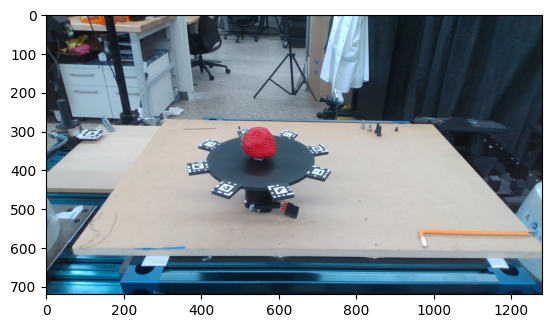

In [10]:
# load the data:
data_path = get_dataset_path('object_pose_estimation_test')
scene_name = 'first_collection'

img = load_image_color(data_path, scene_name, 'camera_1', 2, as_numpy=False)

plt.imshow(img)


In [4]:
# Render the object:
shape_id = 'strawberry'
mesh_path = '/home/mik/robot_ws/src/megapose6d_ros/meshes/strawberry/nontextured.ply'

w_pose_cf = compute_camera_pose(np.array([.2, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
K = np.array([[600., 0., 320.], [0., 600., 240.], [0., 0., 1.]])
camera = Camera(w_pose_cf)
vision_cameras = [camera]
vs_renderer = VisionSceneRenderer(shape_id=shape_id, vision_cameras=vision_cameras, mesh_path=mesh_path, mesh_scale=0.001)


In [5]:
# test visual rendering:

# sample a set of random poses:
num_poses = 500
pos = np.random.rand(num_poses, 3) * 0.01
rpys = np.random.uniform(-np.pi, np.pi, (num_poses, 3))
poses = np.concatenate([pos, rpys], axis=1)
w_X_of = pose_to_matrix(poses)
vision_obs = vs_renderer.render_vision_color(w_X_of=w_X_of)

100%|██████████| 500/500 [00:00<00:00, 837.41it/s]


In [9]:
vision_obs[0].shape

(500, 3, 400, 400)

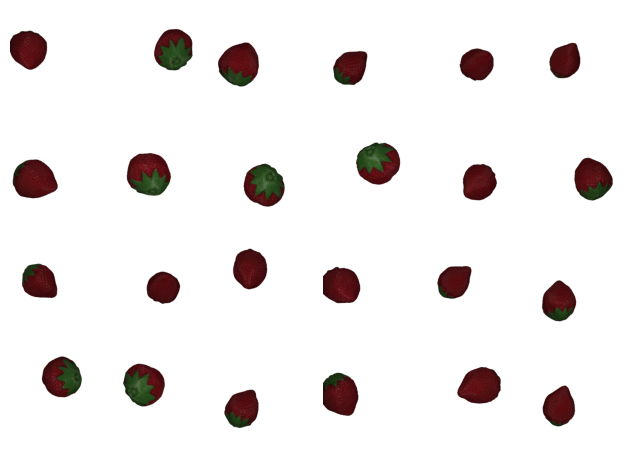

In [13]:
# view vision observations:
num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols)
for row_indx, ax_row in enumerate(axes):
    for col_indx, ax_i in enumerate(ax_row):
        ax_i.imshow(vision_obs[0][row_indx*num_cols+col_indx].transpose(1,2,0))
        ax_i.set_axis_off()
# Apply tight layout
plt.tight_layout()


In [14]:
object_rendered_dataset = [{'rendered_object': img_i} for img_i in vision_obs[0]]

In [15]:
cnos = CNOS(object_rendered_dataset=object_rendered_dataset)


Using cache found in /home/mik/.cache/torch/hub/facebookresearch_dinov2_main
/home/mik/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/mik/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/mik/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [16]:
img.shape

(720, 1280, 3)

In [17]:
mask = cnos.mask(img.transpose(2, 0, 1))

/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: {Half, B

In [18]:
mask.shape

(720, 1280)

In [19]:
masked_img = img * mask[:, :, None]

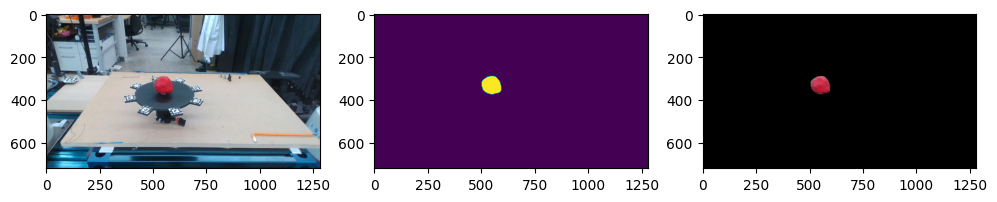

In [20]:
# plot image next to mask and the overlay
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img)
axes[1].imshow(mask)
axes[2].imshow(masked_img)

In [21]:
imgs = [load_image_color(data_path, scene_name, 'camera_1', i, as_numpy=False) for i in range(2, 13)]
masks = [cnos.mask(img_i.transpose(2, 0, 1)) for img_i in imgs]


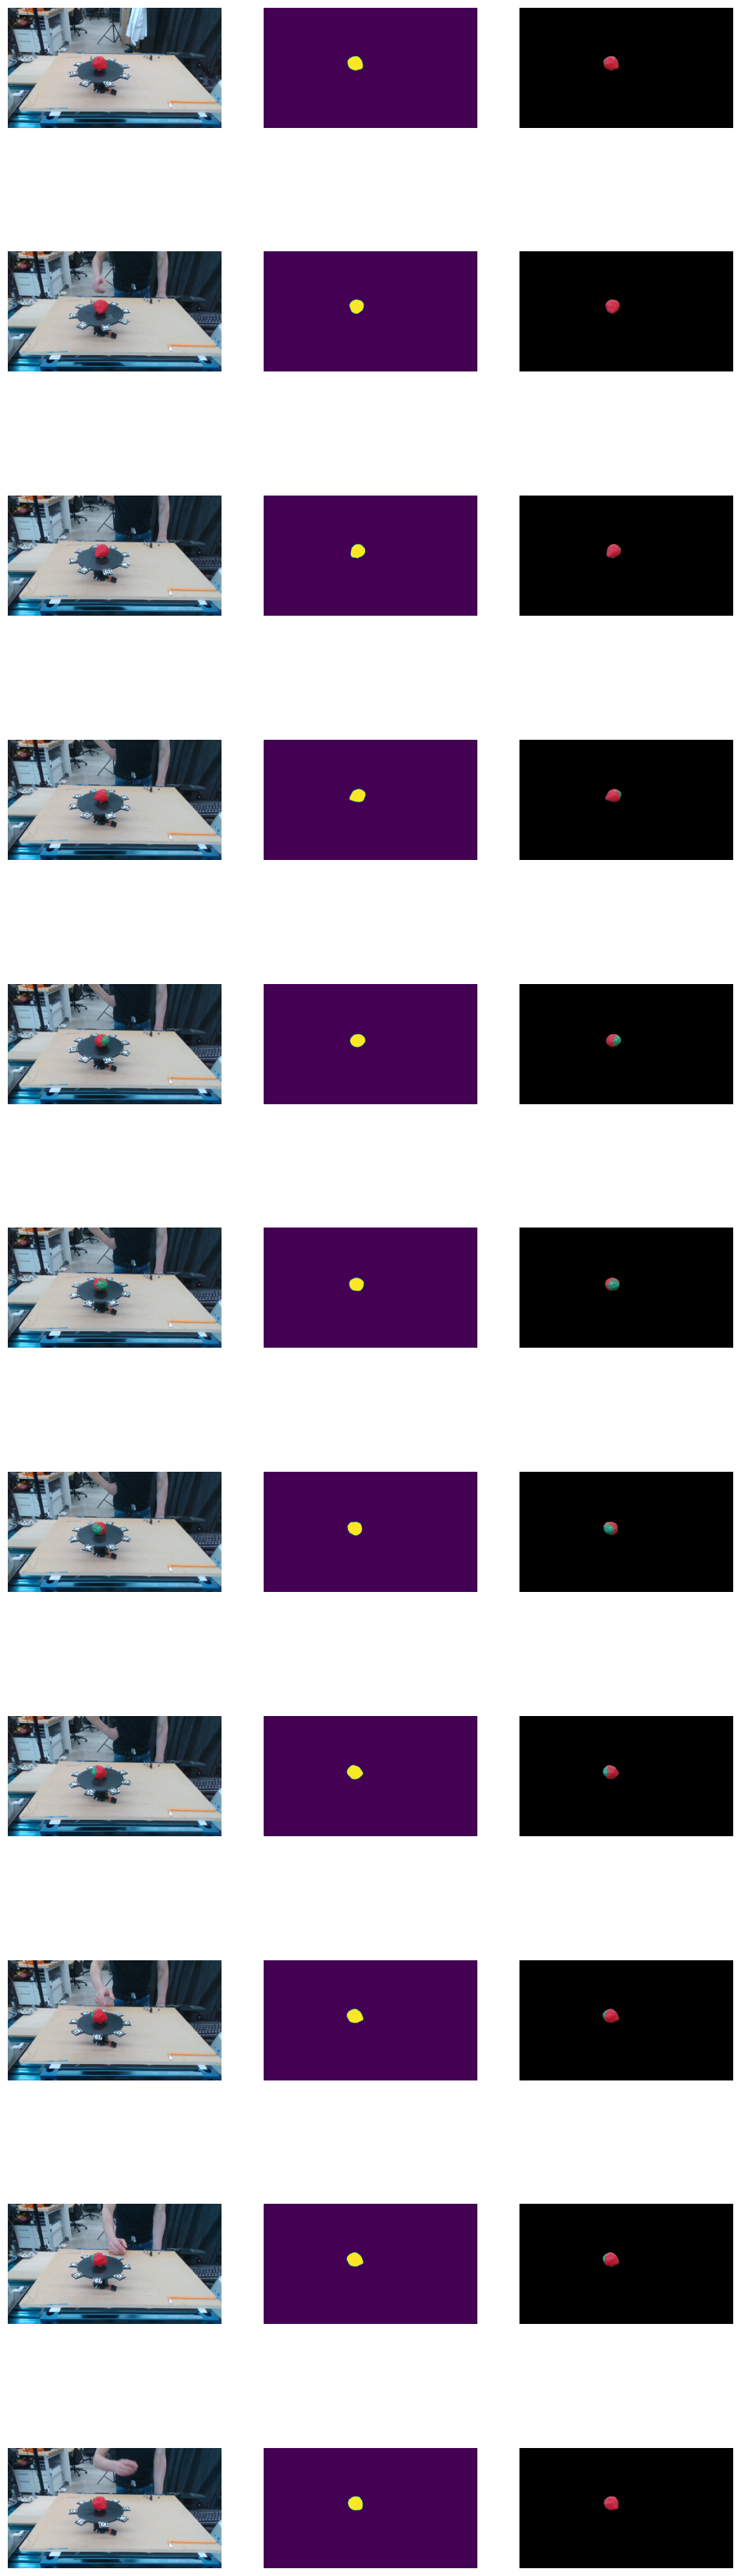

In [23]:
num_imgs = len(imgs)

masked_imgs = [img_i * mask_i[:, :, None] for img_i, mask_i in zip(imgs, masks)]

fig, axes = plt.subplots(num_imgs, 3, figsize=(12, 4*num_imgs))
for i, (img_i, mask_i, masked_img_i) in enumerate(zip(imgs, masks, masked_imgs)):
    axes[i, 0].imshow(img_i)
    axes[i, 1].imshow(mask_i)
    axes[i, 2].imshow(masked_img_i)
    for ax_i in axes[i]:
        ax_i.axis('off')

In [25]:
cnos.sam_wrapper.sam_predictor.predict()

RuntimeError: An image must be set with .set_image(...) before mask prediction.

In [5]:
# Try with another sample with the rubik's cube

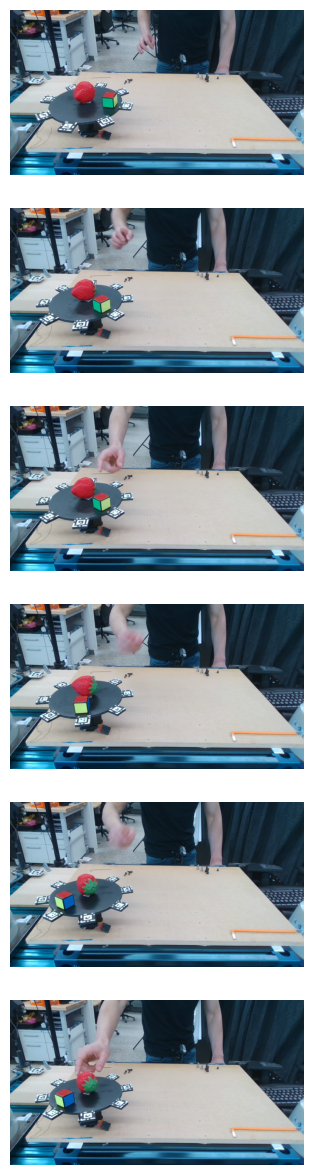

In [11]:
fcs = [31, 32, 33, 34, 35, 36]

imgs = [load_image_color(data_path, scene_name, 'camera_1', fc, as_numpy=False) for fc in fcs]

# visualize the images
fig, axes = plt.subplots(len(fcs), 1, figsize=(5, 2.5*len(fcs)))
for ax, img_i in zip(axes, imgs):
    ax.imshow(img_i)
    ax.axis('off')

In [12]:
# Try the same but with mik cube:
from mik_tools.aux.package_utils import get_test_mesh_path
shape_id = 'rubik_block'
mesh_path = get_test_mesh_path('rubik_block.ply')

w_pose_cf = compute_camera_pose(np.array([.2, 0.0, 0.0]), np.array([0.0, 0.0, 0.0]))
K = np.array([[600., 0., 320.], [0., 600., 240.], [0., 0., 1.]])
camera = Camera(w_pose_cf)
vision_cameras = [camera]

vs_renderer = VisionSceneRenderer(shape_id=shape_id, vision_cameras=vision_cameras, mesh_path=mesh_path,
                                  mesh_scale=0.002)


In [13]:
# sample a set of random poses:
num_poses = 500
pos = np.random.rand(num_poses, 3) * 0.01
rpys = np.random.uniform(-np.pi, np.pi, (num_poses, 3))
poses = np.concatenate([pos, rpys], axis=1)
w_X_of = pose_to_matrix(poses)
vision_obs = vs_renderer.render_vision_color(w_X_of=w_X_of)

object_rendered_dataset = [{'rendered_object': img_i} for img_i in vision_obs[0]]

100%|██████████| 500/500 [00:00<00:00, 667.90it/s]


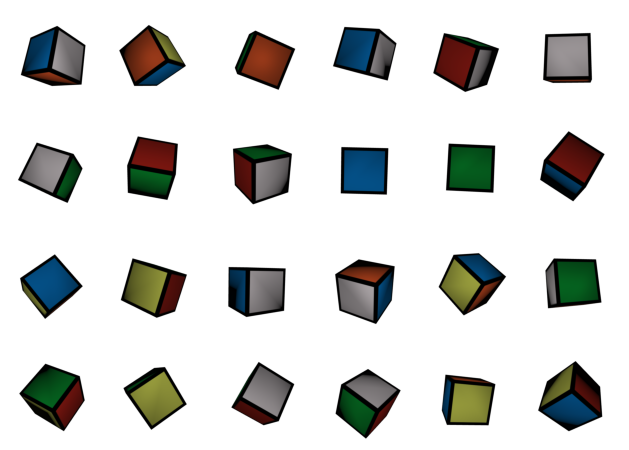

In [14]:
# view vision observations:
num_rows = 4
num_cols = 6
fig, axes = plt.subplots(num_rows, num_cols)
for row_indx, ax_row in enumerate(axes):
    for col_indx, ax_i in enumerate(ax_row):
        ax_i.imshow(vision_obs[0][row_indx*num_cols+col_indx].transpose(1,2,0))
        ax_i.set_axis_off()
# Apply tight layout
plt.tight_layout()

In [15]:
cnos = CNOS(object_rendered_dataset=object_rendered_dataset)


Using cache found in /home/mik/.cache/torch/hub/facebookresearch_dinov2_main


In [16]:
masks = [cnos.mask(img_i.transpose(2, 0, 1)) for img_i in imgs]

/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/mik/MERL/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: {Half, B

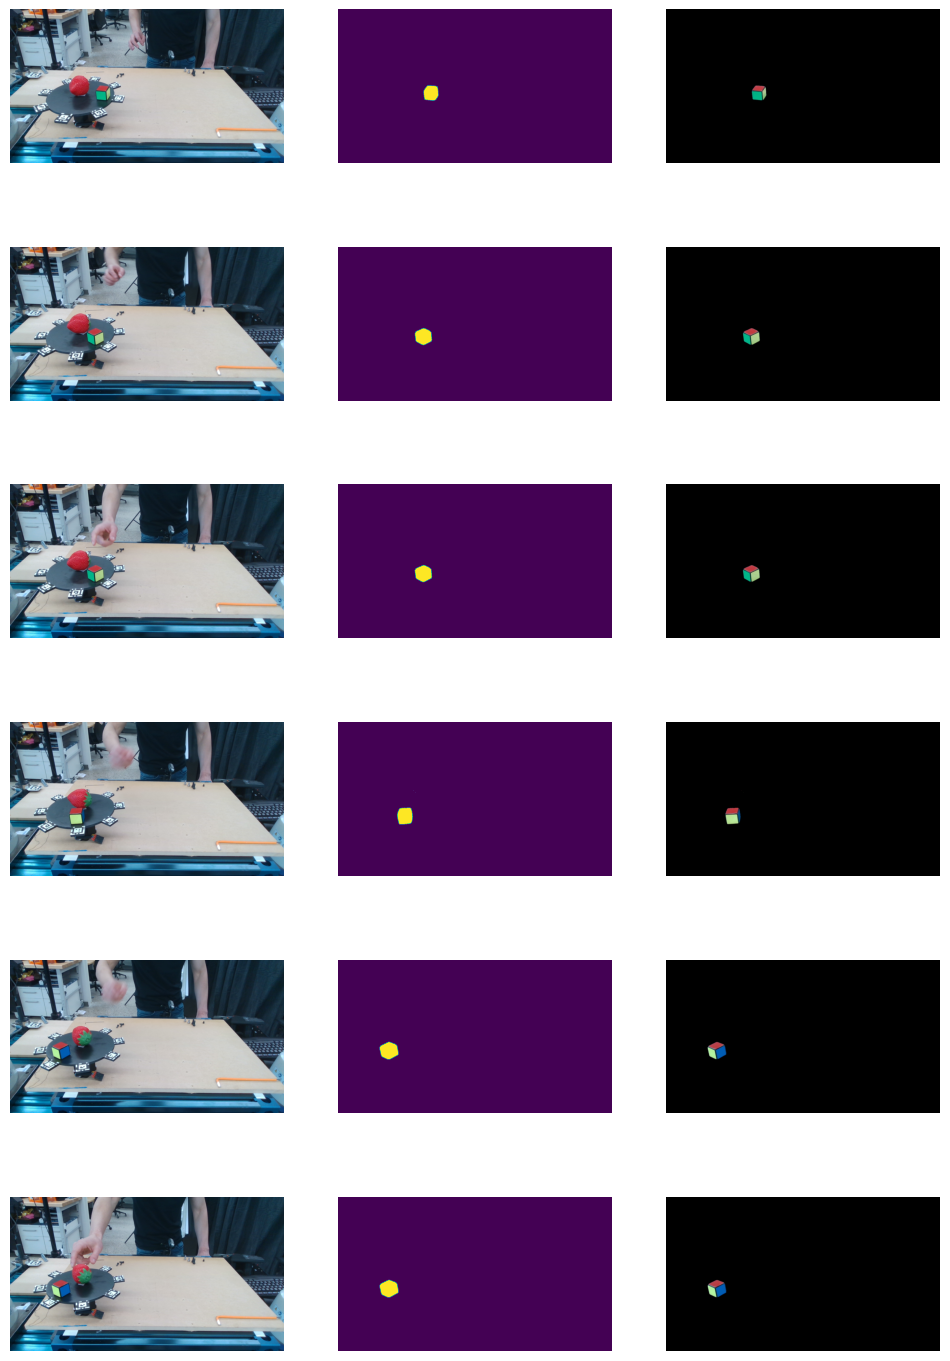

In [17]:
num_imgs = len(imgs)

masked_imgs = [img_i * mask_i[:, :, None] for img_i, mask_i in zip(imgs, masks)]

fig, axes = plt.subplots(num_imgs, 3, figsize=(12, 3*num_imgs))
for i, (img_i, mask_i, masked_img_i) in enumerate(zip(imgs, masks, masked_imgs)):
    axes[i, 0].imshow(img_i)
    axes[i, 1].imshow(mask_i)
    axes[i, 2].imshow(masked_img_i)
    for ax_i in axes[i]:
        ax_i.axis('off')
# make a thight layout

In [15]:
strawberry_masks = [cnos.mask(img_i.transpose(2, 0, 1)) for img_i in imgs]

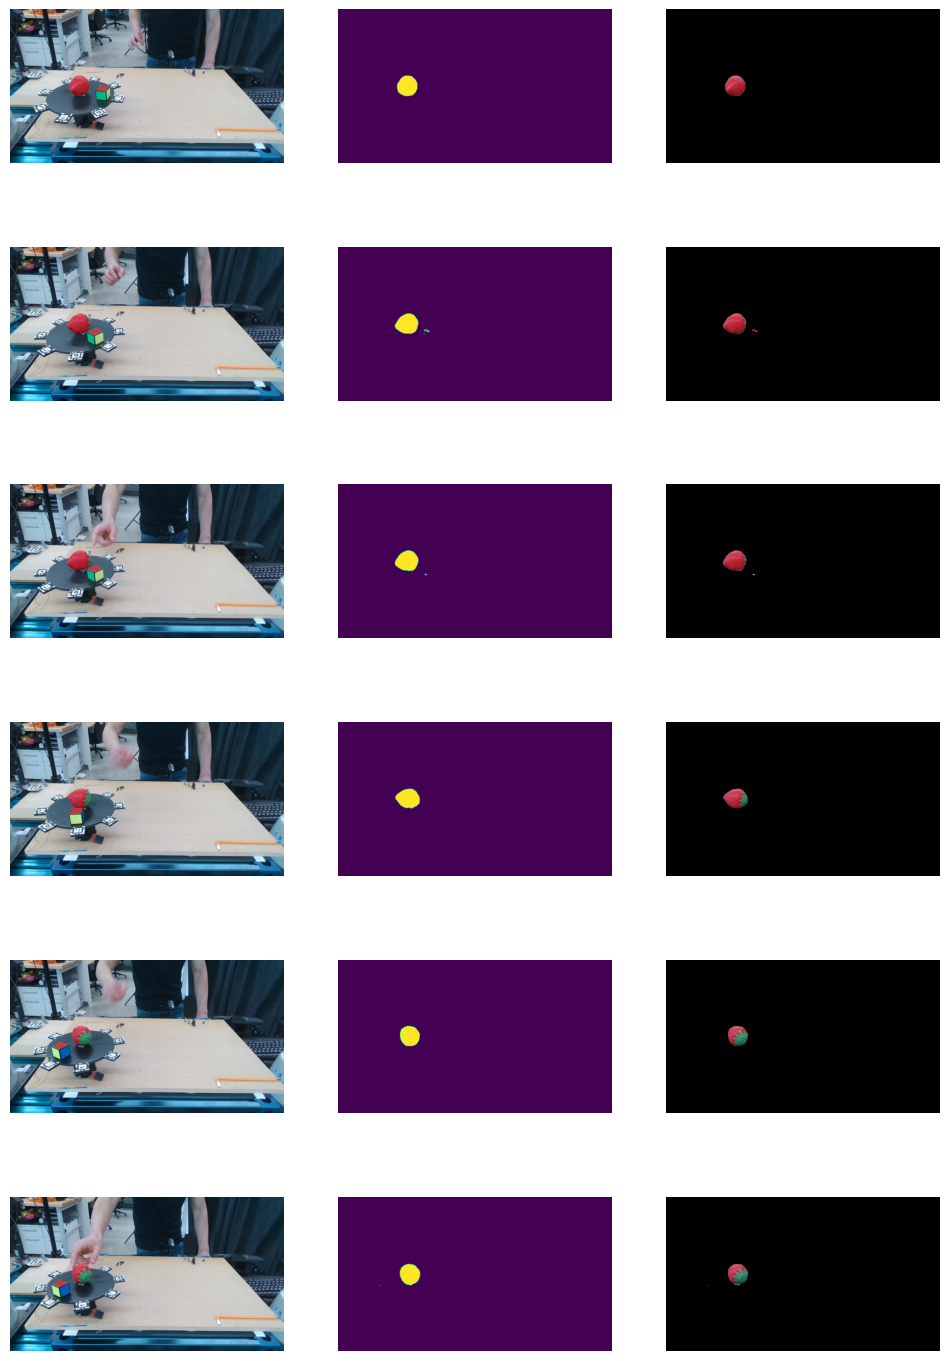

In [19]:
num_imgs = len(imgs)

masked_imgs = [img_i * mask_i[:, :, None] for img_i, mask_i in zip(imgs, strawberry_masks)]

fig, axes = plt.subplots(num_imgs, 3, figsize=(12, 3*num_imgs))
for i, (img_i, mask_i, masked_img_i) in enumerate(zip(imgs, strawberry_masks, masked_imgs)):
    axes[i, 0].imshow(img_i)
    axes[i, 1].imshow(mask_i)
    axes[i, 2].imshow(masked_img_i)
    for ax_i in axes[i]:
        ax_i.axis('off')